In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import platform
# 设置中文字体，兼容不同操作系统
ios = platform.system()
if ios == 'Darwin':  # macOS
    matplotlib.rc('font', family='Arial Unicode MS')
elif ios == 'Windows':
    matplotlib.rc('font', family='SimHei')
else:
    matplotlib.rc('font', family='DejaVu Sans')
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


In [5]:

# 1. 读取数据
df = pd.read_csv('train.csv')

# 2. 基本信息
def basic_info(df):
    print('数据集基本信息:')
    print(df.info())
    print('\n前5行:')
    print(df.head())
    print('\n描述统计:')
    print(df.describe(include='all'))
    print('\n缺失值统计:')
    print(df.isnull().sum())

basic_info(df)


数据集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139930 entries, 0 to 139929
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       139930 non-null  int64  
 1   country                  139930 non-null  object 
 2   property_type            139930 non-null  object 
 3   furnishing_status        139930 non-null  object 
 4   property_size_sqft       139930 non-null  int64  
 5   price                    139930 non-null  int64  
 6   constructed_year         139930 non-null  int64  
 7   previous_owners          139930 non-null  int64  
 8   rooms                    139930 non-null  int64  
 9   bathrooms                139930 non-null  int64  
 10  garage                   139930 non-null  int64  
 11  garden                   139930 non-null  int64  
 12  crime_cases_reported     139930 non-null  int64  
 13  legal_cases_on_property  139930 non-null  int64  


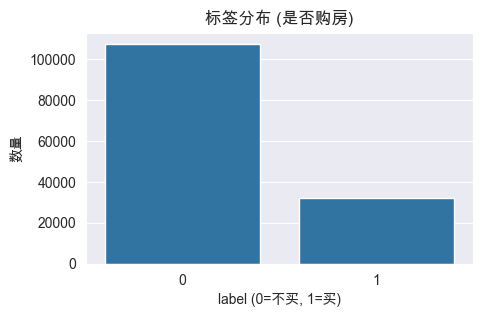

标签分布:
label
0    107610
1     32320
Name: count, dtype: int64


In [6]:
# 3. 标签分布
plt.figure(figsize=(5,3))
sns.countplot(x='label', data=df)
plt.title('标签分布 (是否购房)')
plt.xlabel('label (0=不买, 1=买)')
plt.ylabel('数量')
plt.show()
print('标签分布:')
print(df['label'].value_counts())


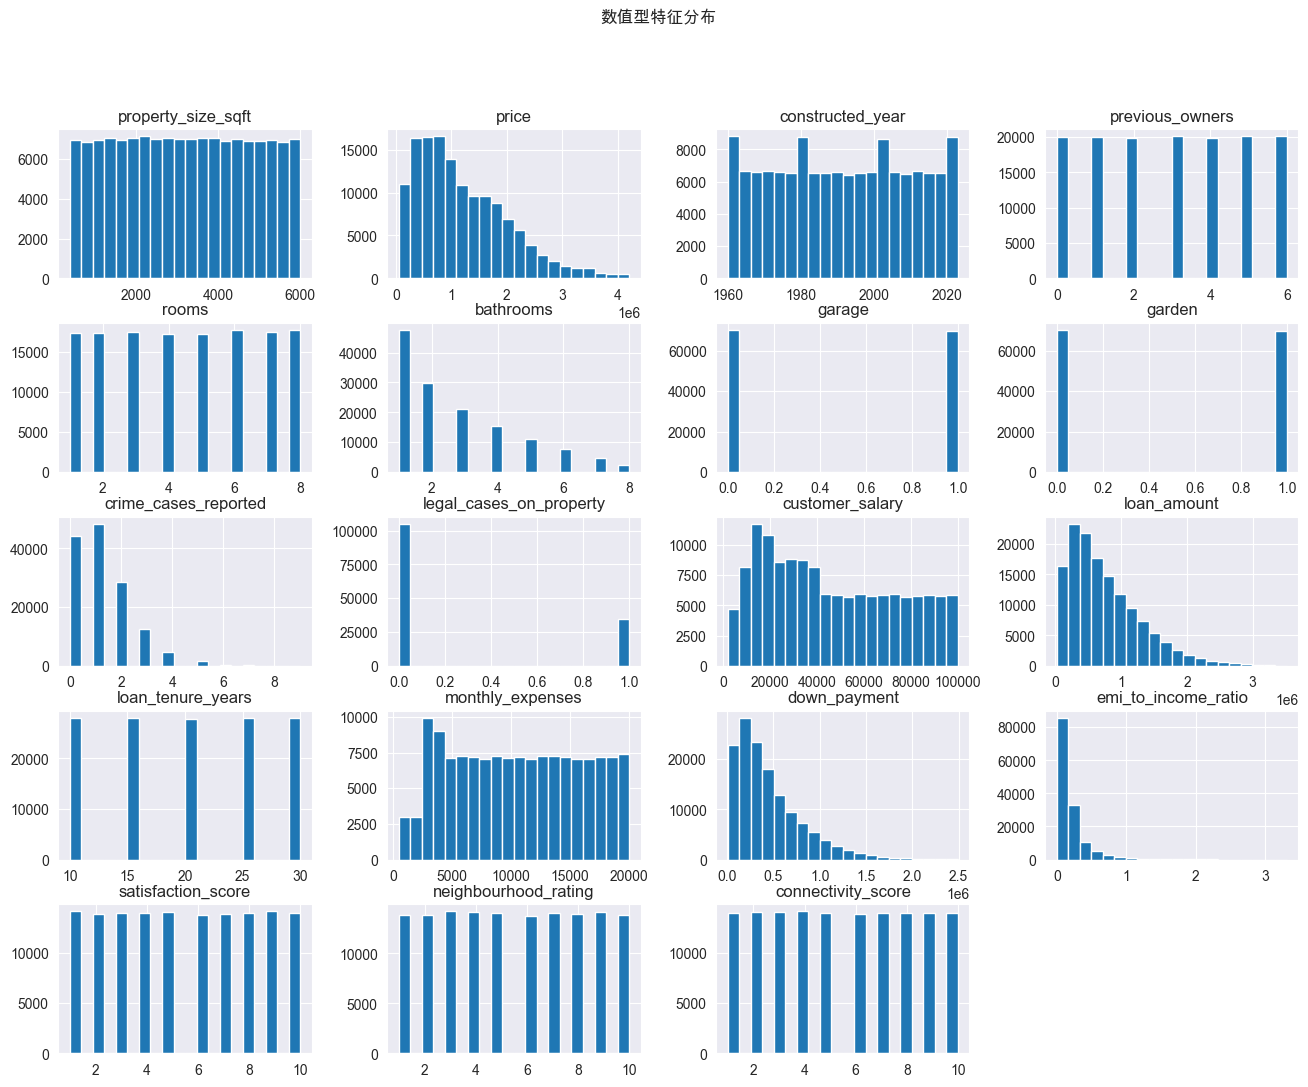

In [7]:
# 4. 数值型特征分布
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col not in ['id', 'label']]
df[num_cols].hist(figsize=(16, 12), bins=20)
plt.suptitle('数值型特征分布')
plt.show()


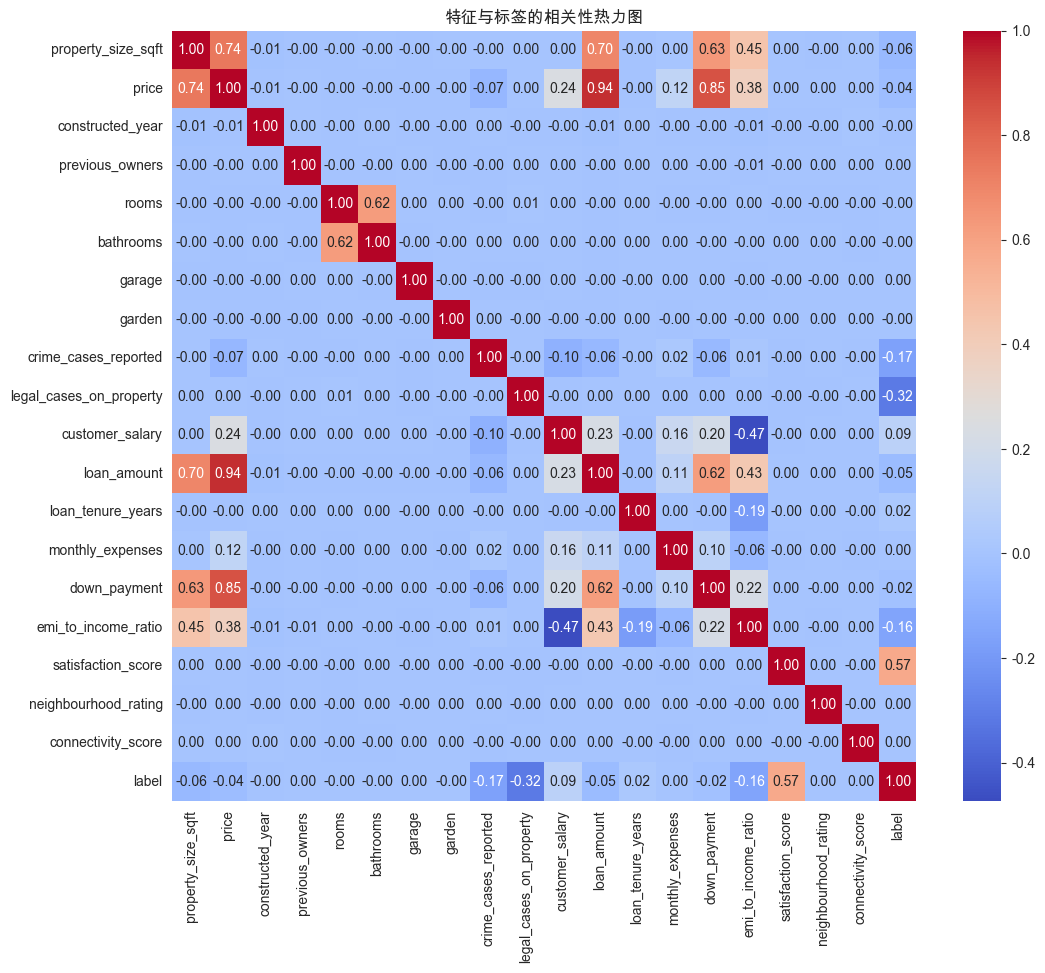

In [8]:

# 5. 相关性分析
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols + ['label']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('特征与标签的相关性热力图')
plt.show()


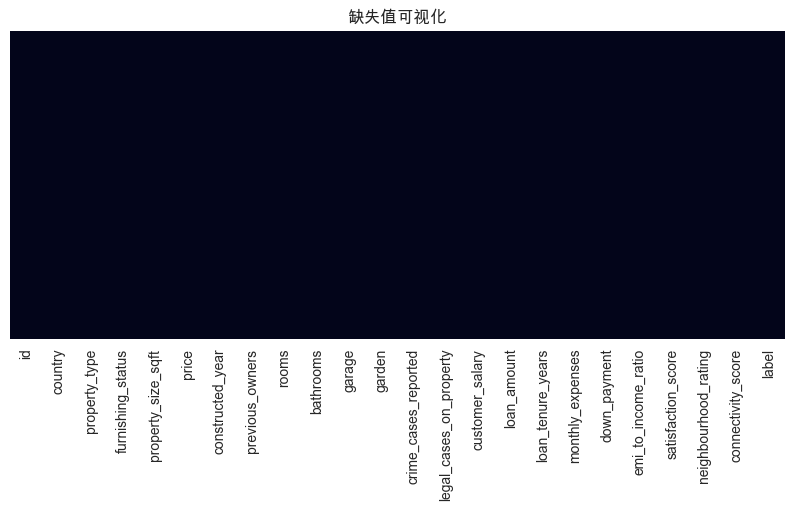

In [9]:
# 6. 缺失值可视化
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title('缺失值可视化')
plt.show()



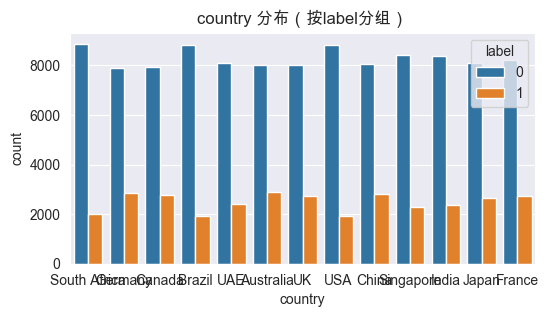

country
France          10946
Australia       10884
South Africa    10869
China           10850
Brazil          10743
USA             10739
India           10738
UK              10736
Canada          10735
Japan           10734
Germany         10726
Singapore       10699
UAE             10531
Name: count, dtype: int64


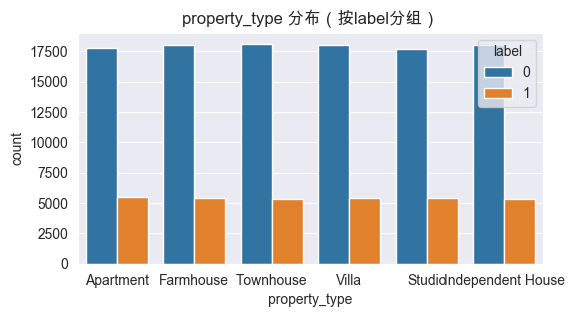

property_type
Townhouse            23471
Villa                23455
Farmhouse            23360
Independent House    23300
Apartment            23271
Studio               23073
Name: count, dtype: int64


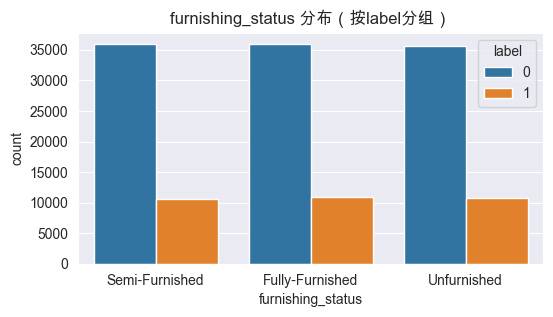

furnishing_status
Fully-Furnished    46869
Semi-Furnished     46623
Unfurnished        46438
Name: count, dtype: int64


In [10]:
# 7. 类别型特征分析（如有）
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df, hue='label')
    plt.title(f'{col} 分布（按label分组）')
    plt.show()
    print(df[col].value_counts())

In [ ]:
# 8. 连续型特征详细分析 - 识别过拟合风险
print("="*60)
print("连续型特征详细分析 - 识别过拟合风险")
print("="*60)

# 获取所有数值型特征（排除id和label）
continuous_features = [col for col in df.select_dtypes(include=[np.number]).columns 
                      if col not in ['id', 'label']]

print(f"连续型特征数量: {len(continuous_features)}")
print(f"特征列表: {continuous_features}")

# 为每个连续特征计算关键统计指标
feature_stats = {}
for feature in continuous_features:
    data = df[feature]
    stats = {
        'count': len(data),
        'mean': data.mean(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        'range': data.max() - data.min(),
        'cv': data.std() / data.mean() if data.mean() != 0 else 0,  # 变异系数
        'skewness': data.skew(),
        'kurtosis': data.kurtosis(),
        'unique_values': data.nunique(),
        'unique_ratio': data.nunique() / len(data),  # 唯一值比例
        'q25': data.quantile(0.25),
        'q50': data.quantile(0.50),
        'q75': data.quantile(0.75),
        'iqr': data.quantile(0.75) - data.quantile(0.25)
    }
    feature_stats[feature] = stats

# 创建统计汇总表
stats_df = pd.DataFrame(feature_stats).T
print("\n连续型特征统计汇总:")
print(stats_df.round(4))


In [ ]:
# 9. 识别过拟合风险特征
print("\n" + "="*60)
print("过拟合风险特征识别")
print("="*60)

# 定义过拟合风险指标
overfitting_risks = {}

for feature in continuous_features:
    stats = feature_stats[feature]
    risks = []
    
    # 1. 高变异系数 (>1.0) - 数据波动大
    if stats['cv'] > 1.0:
        risks.append(f"高变异系数 ({stats['cv']:.2f})")
    
    # 2. 高偏度 (>2 或 <-2) - 分布严重偏斜
    if abs(stats['skewness']) > 2:
        risks.append(f"高偏度 ({stats['skewness']:.2f})")
    
    # 3. 高峰度 (>3) - 分布过于集中
    if stats['kurtosis'] > 3:
        risks.append(f"高峰度 ({stats['kurtosis']:.2f})")
    
    # 4. 高唯一值比例 (>0.8) - 数据过于分散
    if stats['unique_ratio'] > 0.8:
        risks.append(f"高唯一值比例 ({stats['unique_ratio']:.2f})")
    
    # 5. 极大值范围 - 可能存在异常值
    if stats['range'] > 10 * stats['std']:
        risks.append(f"极大值范围 ({stats['range']:.0f} vs std: {stats['std']:.0f})")
    
    overfitting_risks[feature] = risks

# 显示风险特征
high_risk_features = []
for feature, risks in overfitting_risks.items():
    if risks:
        print(f"\n{feature}:")
        for risk in risks:
            print(f"  - {risk}")
        high_risk_features.append(feature)

print(f"\n高风险特征数量: {len(high_risk_features)}")
print(f"高风险特征: {high_risk_features}")

# 按风险程度排序
risk_scores = {}
for feature in continuous_features:
    score = len(overfitting_risks[feature])
    risk_scores[feature] = score

sorted_risks = sorted(risk_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\n按风险程度排序的特征:")
for feature, score in sorted_risks:
    if score > 0:
        print(f"  {feature}: {score} 个风险指标")


In [ ]:
# 10. 高风险特征的详细分布分析
print("\n" + "="*60)
print("高风险特征详细分布分析")
print("="*60)

# 选择前5个最高风险的特征进行详细分析
top_risk_features = [feature for feature, score in sorted_risks[:5] if score > 0]

if top_risk_features:
    fig, axes = plt.subplots(len(top_risk_features), 2, figsize=(15, 4*len(top_risk_features)))
    if len(top_risk_features) == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature in enumerate(top_risk_features):
        data = df[feature]
        
        # 直方图
        axes[i, 0].hist(data, bins=50, alpha=0.7, edgecolor='black')
        axes[i, 0].set_title(f'{feature} - 分布直方图')
        axes[i, 0].set_xlabel(feature)
        axes[i, 0].set_ylabel('频次')
        axes[i, 0].grid(True, alpha=0.3)
        
        # 箱线图
        axes[i, 1].boxplot(data)
        axes[i, 1].set_title(f'{feature} - 箱线图')
        axes[i, 1].set_ylabel(feature)
        axes[i, 1].grid(True, alpha=0.3)
        
        # 打印详细统计
        print(f"\n{feature} 详细统计:")
        print(f"  均值: {data.mean():.2f}")
        print(f"  标准差: {data.std():.2f}")
        print(f"  变异系数: {data.std()/data.mean():.2f}")
        print(f"  偏度: {data.skew():.2f}")
        print(f"  峰度: {data.kurtosis():.2f}")
        print(f"  唯一值数量: {data.nunique()}")
        print(f"  唯一值比例: {data.nunique()/len(data):.2f}")
        print(f"  范围: {data.min():.2f} - {data.max():.2f}")
        
        # 分位数信息
        print(f"  分位数: Q25={data.quantile(0.25):.2f}, Q50={data.quantile(0.5):.2f}, Q75={data.quantile(0.75):.2f}")
    
    plt.tight_layout()
    plt.show()
else:
    print("没有发现高风险特征")


In [ ]:
# 11. 设计分区间策略
print("\n" + "="*60)
print("分区间策略设计")
print("="*60)

def design_binning_strategy(feature_name, data, label_data):
    """
    为单个特征设计分区间策略
    """
    print(f"\n{feature_name} 分区间策略设计:")
    
    # 基本统计
    n_unique = data.nunique()
    n_total = len(data)
    unique_ratio = n_unique / n_total
    
    print(f"  唯一值数量: {n_unique}")
    print(f"  唯一值比例: {unique_ratio:.3f}")
    
    # 策略选择逻辑
    strategy = None
    n_bins = None
    bin_edges = None
    
    if unique_ratio > 0.8:
        # 高唯一值比例 - 需要分区间
        if data.skew() > 2 or data.skew() < -2:
            # 高偏度 - 使用分位数分区间
            strategy = "分位数分区间 (等频)"
            n_bins = min(10, max(5, int(np.sqrt(n_unique))))
            bin_edges = [data.quantile(i/n_bins) for i in range(n_bins+1)]
            bin_edges[0] = data.min()  # 确保包含最小值
            bin_edges[-1] = data.max()  # 确保包含最大值
        else:
            # 低偏度 - 使用等宽分区间
            strategy = "等宽分区间"
            n_bins = min(10, max(5, int(np.sqrt(n_unique))))
            bin_edges = np.linspace(data.min(), data.max(), n_bins+1)
    elif unique_ratio > 0.5:
        # 中等唯一值比例 - 适度分区间
        strategy = "适度分区间"
        n_bins = min(8, max(4, int(np.sqrt(n_unique))))
        if data.skew() > 1.5 or data.skew() < -1.5:
            # 中等偏度 - 使用分位数
            bin_edges = [data.quantile(i/n_bins) for i in range(n_bins+1)]
            bin_edges[0] = data.min()
            bin_edges[-1] = data.max()
        else:
            # 低偏度 - 使用等宽
            bin_edges = np.linspace(data.min(), data.max(), n_bins+1)
    else:
        # 低唯一值比例 - 保持原值或轻微分区间
        strategy = "保持原值或轻微分区间"
        n_bins = min(5, max(3, int(np.sqrt(n_unique))))
        bin_edges = np.linspace(data.min(), data.max(), n_bins+1)
    
    print(f"  推荐策略: {strategy}")
    print(f"  分区间数量: {n_bins}")
    print(f"  分区间边界: {[f'{x:.2f}' for x in bin_edges]}")
    
    # 计算分区间后的信息增益
    if n_bins > 1:
        binned_data = pd.cut(data, bins=bin_edges, include_lowest=True, duplicates='drop')
        
        # 计算每个区间的标签分布
        bin_label_dist = pd.crosstab(binned_data, label_data)
        bin_label_dist_pct = bin_label_dist.div(bin_label_dist.sum(axis=1), axis=0)
        
        print(f"  分区间后标签分布:")
        for i, (bin_name, dist) in enumerate(bin_label_dist_pct.iterrows()):
            print(f"    区间 {i+1} ({bin_name}): 类别0={dist[0]:.3f}, 类别1={dist[1]:.3f}")
    
    return {
        'strategy': strategy,
        'n_bins': n_bins,
        'bin_edges': bin_edges,
        'unique_ratio': unique_ratio
    }

# 为所有连续特征设计分区间策略
binning_strategies = {}
for feature in continuous_features:
    binning_strategies[feature] = design_binning_strategy(
        feature, df[feature], df['label']
    )


In [ ]:
# 12. 分区间策略汇总和建议
print("\n" + "="*60)
print("分区间策略汇总和建议")
print("="*60)

# 创建策略汇总表
strategy_summary = []
for feature, strategy_info in binning_strategies.items():
    strategy_summary.append({
        'feature': feature,
        'strategy': strategy_info['strategy'],
        'n_bins': strategy_info['n_bins'],
        'unique_ratio': strategy_info['unique_ratio'],
        'risk_level': len(overfitting_risks[feature])
    })

strategy_df = pd.DataFrame(strategy_summary)
strategy_df = strategy_df.sort_values('risk_level', ascending=False)

print("分区间策略汇总表:")
print(strategy_df.to_string(index=False))

# 按策略类型分组
strategy_groups = strategy_df.groupby('strategy')
print(f"\n按策略类型分组:")
for strategy, group in strategy_groups:
    print(f"\n{strategy} ({len(group)} 个特征):")
    for _, row in group.iterrows():
        print(f"  - {row['feature']}: {row['n_bins']} 个区间, 风险等级: {row['risk_level']}")

# 实施建议
print(f"\n" + "="*60)
print("实施建议")
print("="*60)

print("""
基于数据分析，以下是对决策树过拟合问题的分区间处理建议：

1. 高优先级特征（必须分区间）:
   - 高唯一值比例 (>0.8) 的特征
   - 高变异系数的特征
   - 高偏度的特征

2. 分区间策略选择原则:
   - 等宽分区间: 适用于分布相对均匀的特征
   - 分位数分区间: 适用于偏斜分布的特征
   - 区间数量: 5-10个区间，避免过多或过少

3. 实施步骤:
   - 首先处理最高风险的特征
   - 逐步验证分区间效果
   - 监控模型泛化能力改善

4. 预期效果:
   - 减少决策树的复杂度
   - 提高模型泛化能力
   - 降低过拟合风险
""")

# 生成具体的实施代码建议
print(f"\n" + "="*60)
print("代码实施建议")
print("="*60)

print("""
在preprocess_data函数中添加以下分区间处理代码:

```python
def apply_binning_strategies(df, binning_strategies):
    \"\"\"应用分区间策略\"\"\"
    df_binned = df.copy()
    
    for feature, strategy_info in binning_strategies.items():
        if strategy_info['n_bins'] > 1:
            bin_edges = strategy_info['bin_edges']
            df_binned[feature] = pd.cut(df[feature], bins=bin_edges, 
                                       include_lowest=True, duplicates='drop')
            # 转换为数值标签
            df_binned[feature] = df_binned[feature].cat.codes
    
    return df_binned
```

关键特征的分区间参数:
""")

# 输出关键特征的具体参数
high_priority_features = strategy_df[strategy_df['risk_level'] >= 2]['feature'].tolist()
for feature in high_priority_features[:5]:  # 只显示前5个
    strategy_info = binning_strategies[feature]
    print(f"\n{feature}:")
    print(f"  策略: {strategy_info['strategy']}")
    print(f"  区间数: {strategy_info['n_bins']}")
    print(f"  边界: {[f'{x:.2f}' for x in strategy_info['bin_edges']]}")
